In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import seaborn as sns
import pandas as pd
import japanize_matplotlib
import numpy as np

from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_validate

from utils import load_data, PropertyDataTransformer

In [2]:
X, y = load_data()

pt = PropertyDataTransformer(formula = """
price ~
is_house +
(
    is_new +
    date +
    C(building_type, contr.treatment('NA')) +
    C(building_type, contr.treatment('NA')):age
):house_m2 +
(
    date +
    nearest_station_name +
    nearest_station_minutes +
    road +
    C(floor_ratio, contr.treatment('150.0')) +
    C(building_ratio, contr.treatment('60.0')) +
    C(orientation, contr.treatment('接面道路無')) +
    C(land_shape, contr.treatment('正方形'))
):land_m2
- 1
""")
X = pt.fit_transform(X)

In [3]:
model = LassoCV(alphas=[0.1, 1, 10, 100, 1000, 10000], max_iter=10000, tol=0.1, fit_intercept=False)
scores = pd.DataFrame(
    cross_validate(
        model,
        X, y,
        scoring=['r2', 'neg_mean_absolute_percentage_error'],
        return_train_score=True,
        cv=100
    )
)
model.fit(X, y)
scores.apply([np.mean, np.median], axis=0).T

,mean,median
fit_time,0.648079,0.598804
score_time,0.009131,0.007113
test_r2,0.562104,0.613172
train_r2,0.723886,0.723969
test_neg_mean_absolute_percentage_error,-0.277882,-0.261011
train_neg_mean_absolute_percentage_error,-0.265342,-0.265488


[(-1.0, 0.0)]

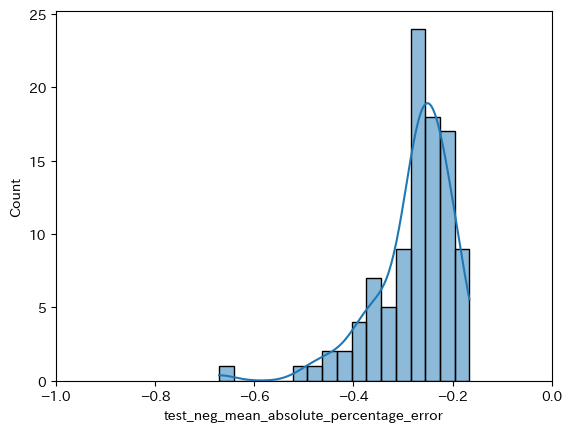

In [4]:
h = sns.histplot(data=scores, x='test_neg_mean_absolute_percentage_error', kde=True)
h.set(xlim=(-1, 0))

In [5]:
s = pd.DataFrame({
    'coef': X.columns,
    'value': model.coef_
})
s.sort_values('value').style.format("{:}")
s[~s['coef'].str.contains('area|nearest')].sort_values('value').style.format("{:}")
# s[s['coef'].str.contains('nearest')].sort_values('value').style.format("{:}")
# s[s['coef'].str.contains('house')].sort_values('value').style.format("{:}")


,coef,value
266,"C(land_shape, contr.treatment('正方形'))[T.不整形]:land_m2",-81255.06935720217
268,"C(land_shape, contr.treatment('正方形'))[T.袋地等]:land_m2",-77426.4521639617
260,"C(orientation, contr.treatment('接面道路無'))[T.東]:land_m2",-27932.829462522477
255,"C(orientation, contr.treatment('接面道路無'))[T.北東]:land_m2",-25249.93567221139
256,"C(orientation, contr.treatment('接面道路無'))[T.北西]:land_m2",-24126.056766006808
261,"C(orientation, contr.treatment('接面道路無'))[T.西]:land_m2",-19211.453480452048
258,"C(orientation, contr.treatment('接面道路無'))[T.南東]:land_m2",-16487.68160875659
267,"C(land_shape, contr.treatment('正方形'))[T.台形]:land_m2",-15580.418111157922
259,"C(orientation, contr.treatment('接面道路無'))[T.南西]:land_m2",-14521.814608182201
272,"C(building_type, contr.treatment('NA'))[軽量鉄骨造]:age:house_m2",-12149.89198107263


In [6]:
x = {
    'is_new': 0,
    'is_house': 1,
    'price': 72800000,
    'orientation': '南',
    'house_m2': 96,
    'land_m2': 88,
    'building_type': '軽量鉄骨造',
    'age': 2025-2015,
    'nearest_station_name': '王子',
    'nearest_station_minutes': 12,
    'building_ratio': str(60.0),
    'floor_ratio': str(150.0),
    'area': '滝野川',
    'area_plan': '１中住専',
    'land_shape': 'ほぼ長方形',
    'next': '住宅',
    'date': int(2025) - 2020,
    'road': 10
}
yy = x['price']
x = pt.model_spec.get_model_matrix(x)
# i = 4340
# x = X.iloc[i:i + 1, :]
x

,is_house,is_new:house_m2,date:house_m2,"C(building_type, contr.treatment('NA'))[NA]:house_m2","C(building_type, contr.treatment('NA'))[木造]:house_m2","C(building_type, contr.treatment('NA'))[軽量鉄骨造]:house_m2","C(building_type, contr.treatment('NA'))[鉄骨造]:house_m2",date:land_m2,nearest_station_name[ときわ台(東京)]:land_m2,nearest_station_name[めじろ台]:land_m2,...,"C(land_shape, contr.treatment('正方形'))[T.ほぼ正方形]:land_m2","C(land_shape, contr.treatment('正方形'))[T.ほぼ長方形]:land_m2","C(land_shape, contr.treatment('正方形'))[T.不整形]:land_m2","C(land_shape, contr.treatment('正方形'))[T.台形]:land_m2","C(land_shape, contr.treatment('正方形'))[T.袋地等]:land_m2","C(land_shape, contr.treatment('正方形'))[T.長方形]:land_m2","C(building_type, contr.treatment('NA'))[NA]:age:house_m2","C(building_type, contr.treatment('NA'))[木造]:age:house_m2","C(building_type, contr.treatment('NA'))[軽量鉄骨造]:age:house_m2","C(building_type, contr.treatment('NA'))[鉄骨造]:age:house_m2"
0,1,0,480,0,0,96,0,440,0,0,...,0,88,0,0,0,0,0,0,960,0


Text(0.5, 1.0, '-5.4% compared to prediction = 7,699万円')

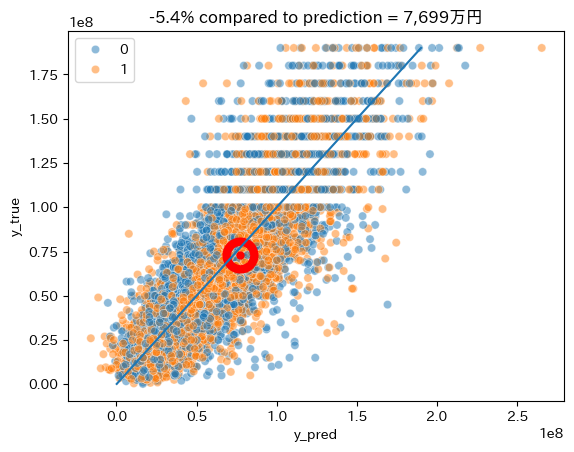

In [7]:
import matplotlib.pyplot as plt

data = pd.DataFrame({
    'y_pred': model.predict(X),
    'y_true': y,
    'is_house': X.is_house
})
sns.scatterplot(data, x='y_pred', y='y_true', hue='is_house', alpha=0.5)
sns.lineplot(data, x='y_true', y='y_true')

# model.fit(X, y.values[:, 0])
yp = model.predict(x)[0]
# yy = y.iloc[i].values[0]
plt.scatter(yp, yy, c='r', linewidths=20)

plt.title(f'{yy / yp - 1:.1%} compared to prediction = {yp / 10000:,.0f}万円')
# plt.xlim(0, 2e8)
# plt.ylim(0, 2e8)

In [8]:
xx = x.T.reset_index()
xx.columns = ['coef', 'value']
xx
xxx = xx.merge(s, on='coef')
xxx
xxx['m'] = xxx['value_x'] * xxx['value_y'] / 10000
h = xxx[xxx['m'] != 0]
h

,coef,value_x,value_y,m
0,is_house,1,1.243022e+07,1243.021719
2,date:house_m2,480,5.050628e+03,242.430161
5,"C(building_type, contr.treatment('NA'))[軽量鉄骨造]...",96,2.127402e+05,2042.305990
7,date:land_m2,440,2.620818e+04,1153.159853
169,nearest_station_name[王子]:land_m2,88,4.758796e+05,4187.740256
249,nearest_station_minutes:land_m2,1056,-7.209830e+03,-761.358054
250,road:land_m2,880,9.301570e+03,818.538130
257,"C(orientation, contr.treatment('接面道路無'))[T.南]:...",88,-1.085513e+04,-95.525105
265,"C(land_shape, contr.treatment('正方形'))[T.ほぼ長方形]...",88,4.001869e+03,35.216446
272,"C(building_type, contr.treatment('NA'))[軽量鉄骨造]...",960,-1.214989e+04,-1166.389630


In [9]:
house = h[h['coef'].str.contains('house')]['m'].sum()
land = h[h['coef'].str.contains('land')]['m'].sum()
print(f"house = {house:,.0f}\nland = {land:,.0f}\nhouse vs total = {house /(house + land):.2%}")

house = 2,361
land = 5,338
house vs total = 30.67%


In [10]:
import joblib

joblib.dump(pt, 'proptrans.pkl')

['proptrans.pkl']

In [11]:
joblib.dump(model, 'model.pkl')

['model.pkl']

In [15]:
f = joblib.load('model.pkl')

In [16]:
f.predict(x)

array([76991397.65999748])

In [13]:
pt = joblib.load('proptrans.pkl')

In [14]:
x = {
    'is_new': 0,
    'is_house': 1,
    'price': 72800000,
    'orientation': '南',
    'house_m2': 96,
    'land_m2': 88,
    'building_type': '軽量鉄骨造',
    'age': 2025-2015,
    'nearest_station_name': '王子',
    'nearest_station_minutes': 12,
    'building_ratio': str(60.0),
    'floor_ratio': str(150.0),
    'area': '滝野川',
    'area_plan': '１中住専',
    'land_shape': 'ほぼ長方形',
    'next': '住宅',
    'date': int(2025) - 2020,
    'road': 10
}
yy = x['price']
x = pt.model_spec.get_model_matrix(x)